In [1]:
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pywt
import random
import warnings

warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
def make_wave(amps, freqs, T, n_points, ax):
    """
    Creates wave with given amplitudes and frequencies for t from 0 to T
    :param amps: numpy 1d array of amplitudes
    :param freqs: numpy 1d array of linear frequencies
    :param T: float, max value of time
    :param dt: float, step size for time: 0, dt, 2dt, ...
    :return: sum(i = 0, ..., n) amps[i] * sin(2*pi*freqs[i]*t)
    """
    assert(amps.ndim * freqs.ndim == 1)
    assert(amps.shape[0] == freqs.shape[0])
    assert(n_points >= 2)
    n_steps = n_points - 1
    t = np.linspace(0, T, n_steps)
    signal = np.zeros(t.shape)
    for i in range(amps.shape[0]):
        wave = amps[i] * np.sin(2 * np.pi * freqs[i] * t)
        ax.plot(wave)
        signal += wave
    return t, signal

In [3]:
def add_anomaly(signal):
    """
    Modifies the signal adding anomaly at one of its time points
    :param signal: numpy 1d array
    :return: index of time step at which anomaly was added
    """
    n = signal.shape[0]
    assert(n > 2)
    i = random.randint(1, n-1)
    sign = random.randint(0, 1)
    new_signal = copy.deepcopy(signal)
    new_signal[i] = 1.5 * (-1)**sign * (np.max(signal) - np.min(signal))
    return new_signal, i

In [4]:
def init(amps, freqs, T, dt, random_seed=None):
    """
    Creates signal with given amplitudes and frequencies with anomaly at one random time step
    :param amps: 1d-array of amplitudes
    :param freqs: 1d-array of frequencies (must have same length as amps)
    :param T: the signal values will be generated for time from 0 to T
    :param dt: time step (must be 0 < dt < T)
    :return: original signal, signal with anomaly, time step index where anomaly occurred
    """
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    random.seed(random_seed)
    font_size = 12
    
    t, signal = make_wave(amps, freqs, T, dt, ax[0])
    ax[0].set_title('Original signal components', fontsize=font_size)
    
    ax[1].plot(signal)
    ax[1].set_title('Original signal', fontsize=font_size)
    
    new_signal, anomaly_ix = add_anomaly(signal)
    ax[2].plot(new_signal)
    ax[2].plot(anomaly_ix, [new_signal[anomaly_ix]], 'ro', markersize=font_size-4)
    ax[2].set_title('Signal with anomaly', fontsize=font_size)
    
    ylim = ax[2].get_ylim()
    for i in range(3):
        ax[i].tick_params(axis='both', labelsize=font_size-2)
        ax[i].set_ylim(ylim)
    plt.tight_layout()
    plt.show()
    return signal, new_signal, anomaly_ix

In [5]:
def wavelets(signal, wavelet='haar', level=4):
    """
    Applies given discrete wavelet transform and make some plots
    :param signal: 1d-array of signal values
    :param wavelet: wavelet type (all listed at the last cell)
    :param level: numer of levels for wavelet transform
    """
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    N = coeffs[level].shape[0]
    try:
        # creating the scaleogram
        assert((N & (N-1)) == 0)  # works only if N is power of 2
        A = np.zeros((level, N))
        for i in range(1, level+1):
            n = coeffs[i].shape[0]
            Q = N // n
            # (0 ... Q-1)(Q ... 2Q-1) ... ((n-1)Q ... nQ-1)
            for j in range(n):
                A[i-1, j*Q:(j+1)*Q] = coeffs[i][j]
        
        # plotting the scaleogram for signed and absolute values of coefficients
        fig, ax = plt.subplots(2, 1, figsize=(8,5))
        plt.gray()
        
        ax[0].set_yticks([])
        ax[0].imshow(A)
        ax[0].set_title('Signed DWT coefficients')
        
        ax[1].imshow(np.abs(A))
        ax[1].set_yticks([])
        ax[1].set_title('Absolute DWT coefficients')
        
        plt.tight_layout()
        plt.show()
        print('\n\n\n')
    except:
        print("Scaleogram requires 'haar' wavelet and n_points being a power of 2 plus 1.")
    
    
    # plotting the coefficients of wavelet transform
    fig, ax = plt.subplots(level, 1, figsize=(6, 2*level))
    for i in range(level):
        ax[i].stem(coeffs[i+1])
        ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))  # To make xticks integers
        ax[i].set_title('Coefficients at level {}'.format(i+1))
    plt.tight_layout()    
    plt.show()
    
    print('\n\n\n')
    
    # plotting the restored signal for each level
    fig, ax = plt.subplots(level, 1, figsize=(6, 2*level))
    for i in range(level):
        restored = pywt.waverec(coeffs[:i+2], wavelet=wavelet)
        ax[i].plot(restored)
        ax[i].set_title('Signal restored from first {} levels'.format(i+1))
    plt.tight_layout()    
    plt.show()

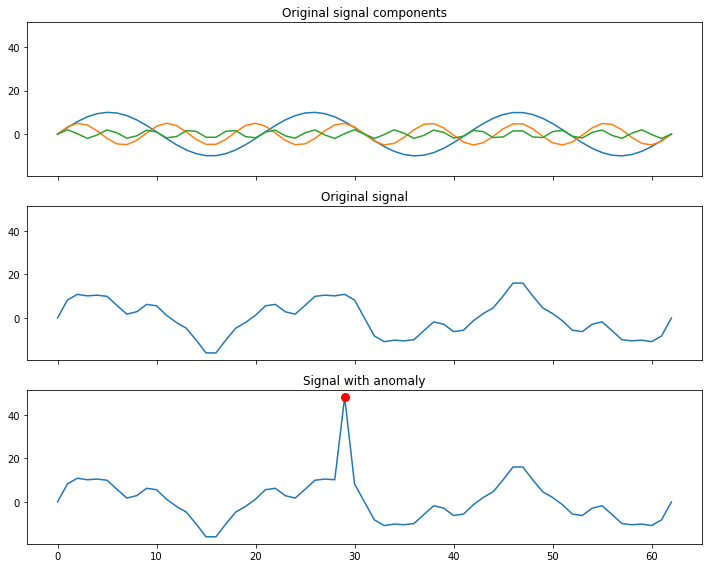

In [6]:
amps = np.array([10, 5, 2])
freqs = np.array([3, 7, 15])

T = 1
n_points = 64

signal, new_signal, anomaly_ix = init(amps, freqs, T, n_points)

Anomaly is at time-point 29


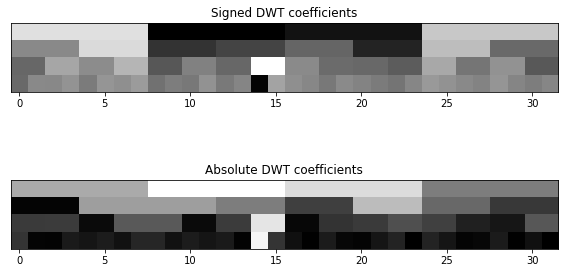

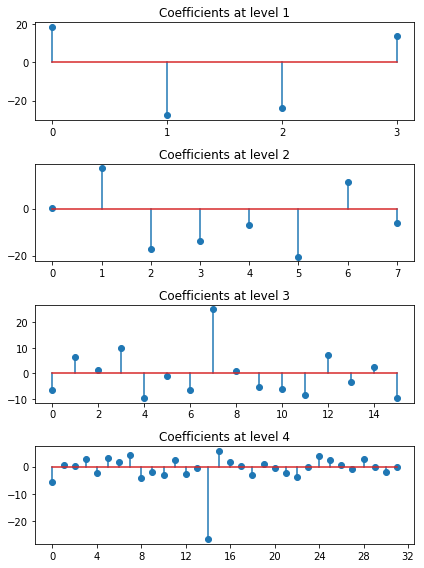

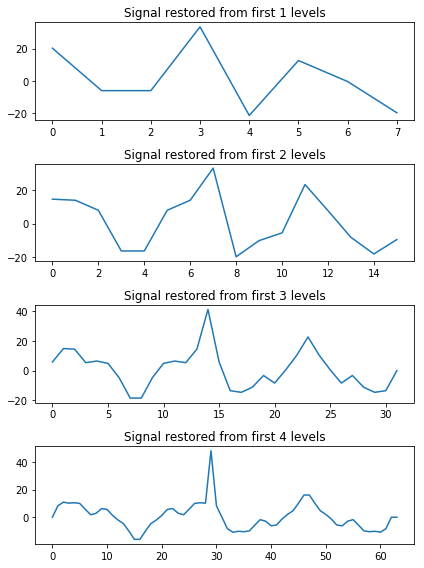

In [7]:
print('Anomaly is at time-point', anomaly_ix)
wavelets(new_signal)

In [8]:
# Available wavelet families:
# Biorthogonal (bior)
# Coiflets (coif)
# Daubechies (db)
# “Discrete” FIR approximation of Meyer wavelet (dmey)
# Haar (haar)
# Reverse biorthogonal (rbio)
# Symlets (sym)

pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',